<a href="https://colab.research.google.com/github/EdisonVazquezG/KnotNet_invariants/blob/main/Predicting_Signature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive/')
my_path = "/Colab Notebooks/" # Your path
gdrive_path = "/content/drive" + "/My Drive" + my_path
sys.path.append(gdrive_path)

import pandas as pd
import numpy as np
import tensorflow as tf
import torch
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import load_model
import torch.optim as optim
from tensorflow.keras.callbacks import EarlyStopping
import umap
import copy
import matplotlib.pyplot as plt
import torch.nn as nn

import knot_utils
import knot_ml_models
import knot_visualizer

import importlib
importlib.reload(knot_utils)
importlib.reload(knot_ml_models)
importlib.reload(knot_visualizer)

from knot_utils import scale_data,preprocess,sampling,drop_,split_data
from knot_ml_models import build_autoencoder,MLP_single,MLP_combined,train_model,evaluate_model
from knot_visualizer import ErrorVisualizer, UMAPVisualizer, PCAVisualizer, SIGNATURE_COLORS


In [ ]:
A = pd.read_csv(gdrive_path + "alexander_15.csv")
J = pd.read_csv(gdrive_path  + "Jones_upto_15_MIRRORS.csv")
H = pd.read_csv(gdrive_path + "hompfly.csv")
signature = A[['signature']]
H_with_signature = copy.deepcopy(H)
H_with_signature['signature'] = signature
## This will work for just keep certain variables that will help in the posterior analysis
J_15 = J[~J['knot_id'].str.contains('!')]
H_15 = H.merge(A[['signature']],left_on=H.index,right_on=A.index)

<ipython-input-4-2830b41fc890>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alexander['knot'] = alexander['number_of_crossings'].astype(str) + '_' + alexander['table_number'].astype(str)


In [ ]:
alexander_p, jones_p, H_p= preprocess(J,A,H,True)
a_f = alexander_p.drop(columns=["Unnamed: 0"]) ## Must be in the preprocess section
a_f = a_f.reset_index(drop=True)
j_f = jones_p.reset_index(drop=True)
H_f = H_p.reset_index(drop=True)
A_cleaned =  drop_(A,145200) ## This will not scaled their coefficients for future analysis
a_c = drop_(a_f,145200)
j_c = drop_(j_f,145200)
H_c = drop_(H_f,145200)
signature_c = A_cleaned[['signature']]

In [ ]:
# Embeddeds
encoder_J = load_model('/content/drive/MyDrive/Colab Notebooks/encoder_jones.h5')
encoder_A = load_model('/content/drive/MyDrive/Colab Notebooks/encoder_alexander.h5')
encoder_H = load_model('/content/drive/MyDrive/Colab Notebooks/encoder_H.h5')

In [ ]:

# 1. Obtener los embeddings con los encoders
emb_j = encoder_J.predict(j_c)
emb_a = encoder_A.predict(a_c)
emb_h = encoder_H.predict(H_c)


9789/9789 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
9789/9789 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step
9789/9789 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


In [ ]:
# 4. Concatenar correctamente
X = np.concatenate([emb_j, emb_a, emb_h], axis=1)  # Forma final: (n_samples, dim_j + dim_a + dim_h)

signature_values = [0, 2, 4, 6, 8, 10, 12]
signature_to_class = {sig: idx for idx, sig in enumerate(signature_values)}
y = np.array([signature_to_class[val] for val in signature_c['signature']])

In [ ]:
# ==== 4. División en train/test ====
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# DataLoaders
batch_size = 256
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)


In [ ]:
# ==== 5. Modelo ====
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = MLP(input_dim=X.shape[1], num_classes=7).to(device)


In [ ]:

# ==== 6. Ponderación de clases ====
class_counts = np.bincount(y)
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights.to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# ==== 7. Entrenamiento ====
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_fn(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)

    # Validación
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_true.extend(yb.numpy())

    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")





Epoch 1 | Loss: 0.2114
Epoch 2 | Loss: 0.0588
Epoch 3 | Loss: 0.0426
Epoch 4 | Loss: 0.0461
Epoch 5 | Loss: 0.0434
Epoch 6 | Loss: 0.0346
Epoch 7 | Loss: 0.0342
Epoch 8 | Loss: 0.0325
Epoch 9 | Loss: 0.0295
Epoch 10 | Loss: 0.0271


In [ ]:
# ==== 8. Reporte ====
print("\nReporte de clasificación (validación):")
print(classification_report(all_true, all_preds, target_names=[f"sig_{s}" for s in signature_to_class.keys()]))


Reporte de clasificación (validación):
              precision    recall  f1-score   support

       sig_0       0.99      0.98      0.98     16003
       sig_2       1.00      1.00      1.00     25679
       sig_4       0.98      0.99      0.98     14201
       sig_6       0.99      0.99      0.99      5411
       sig_8       1.00      0.98      0.99      1227
      sig_10       0.85      1.00      0.92       121
      sig_12       0.57      1.00      0.73         4

    accuracy                           0.99     62646
   macro avg       0.91      0.99      0.94     62646
weighted avg       0.99      0.99      0.99     62646



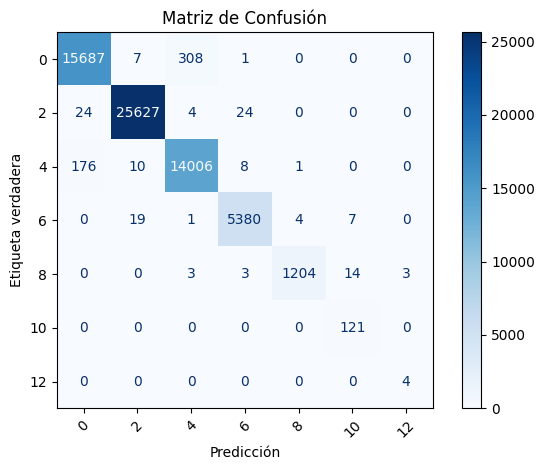

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# y_true: verdaderas etiquetas (clases 0 a 6)
# y_pred: etiquetas predichas (clases 0 a 6)

cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 2, 4, 6, 8, 10, 12])
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta verdadera")
plt.tight_layout()
plt.show()
